In [2]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [3]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #change after Filter implementation
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

from filter import ValidityFilter
filters = [ValidityFilter()]

Search is started.
0- time: 0.19, count_rollouts: 1, reward: -0.3269586034385967, node: PEPTIDE1{Y.G.A.F.L.R.R.I.R.[dP].K}$$$$
1- time: 0.34, count_rollouts: 2, reward: -0.7644601614331529, node: PEPTIDE1{G.C.C.S.H.P.A.C.A.A.N.N.A}$$$$
2- time: 0.43, count_rollouts: 3, reward: -0.6214800982717037, node: PEPTIDE1{[ac].F.Q.S.V.Q.N.V.F.V.D.G.Y.F.E.R.L.A.A.K.L.[am]}$$$$
3- time: 0.71, count_rollouts: 5, reward: -0.32708452446075864, node: PEPTIDE1{Y.A.G.A.V.V.N.D.L}$$$$
4- time: 0.76, count_rollouts: 6, reward: -0.8595763438311921, node: PEPTIDE1{G.V.A.D.S.S.K.D.L.K.E.H.Q.T.K.V.K.D.I.N.V}$$$$
5- time: 0.87, count_rollouts: 7, reward: -0.7008453481177872, node: PEPTIDE1{F.K.K.I.T.L.H.I.A.A.G.V.D.E.K.N.A.A.K.N}$$$$
6- time: 0.99, count_rollouts: 8, reward: -0.7921621748519322, node: PEPTIDE1{A.E.E.L.A.L.E.A.E.L.A.A.L.E.G.N.G.M.S.V.L.S.W.L.G.K.L.A.A.L.K.A.K.L.A.A.L.K.A}$$$$
7- time: 1.17, count_rollouts: 9, reward: -0.7067893452792953, node: PEPTIDE1{T.R.F.R.G.A.R.K.K.S.G}$$$$
8- time: 1.23, 

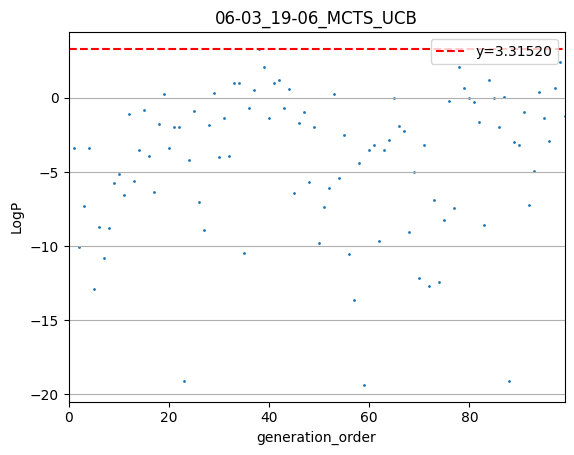

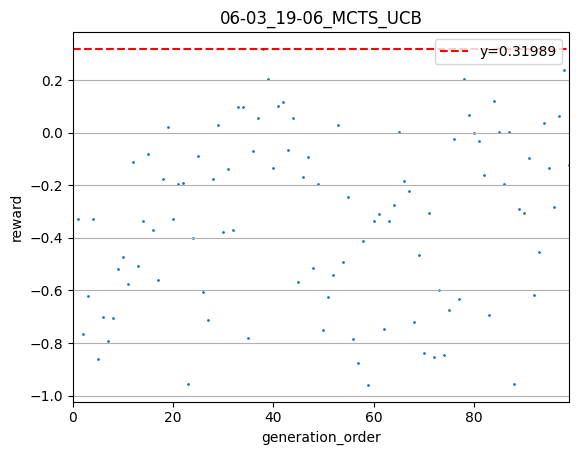

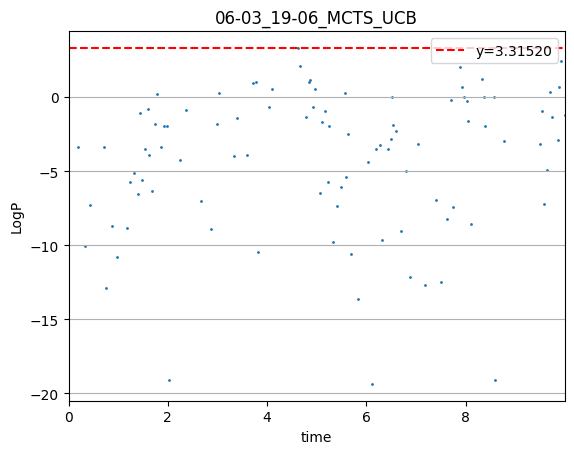

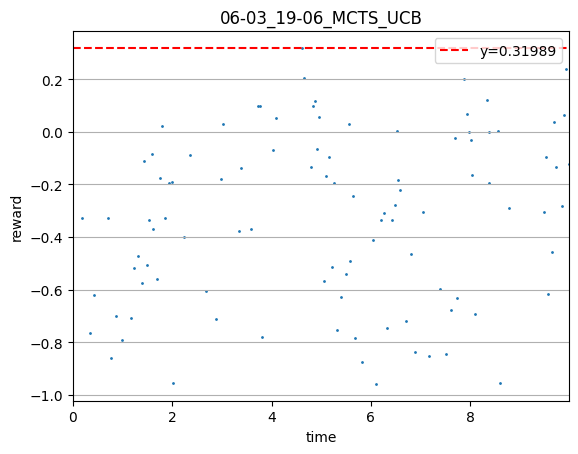

Search is completed.


In [5]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)